In [246]:
import numpy
import pandas
import pandas as pd
import csv
import os
import networkx as nx


In [247]:
tr_path = 'C:/Users/Administrator/Desktop/台科/課程/112-2 社群分析/112-2 Social Media Analytics/hw1 Linkprediction/2024-ntust-practice-of-social-media-analytics-hw1/train.csv'  # path to training data
train_df = pd.read_csv(tr_path)

tt_path = 'C:/Users/Administrator/Desktop/台科/課程/112-2 社群分析/112-2 Social Media Analytics/hw1 Linkprediction/2024-ntust-practice-of-social-media-analytics-hw1/test.csv'   # path to testing data
test_df = pd.read_csv(tt_path)

In [248]:
!nvidia-smi

Sun May  5 18:29:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.92                 Driver Version: 545.92       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   44C    P8              18W / 170W |   1691MiB / 12288MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [249]:
train_df

,node1,node2,label
0,29237,16563,1
1,32869,24548,0
2,48837,17831,1
3,31387,44509,0
4,15102,10271,1
...,...,...,...
31995,51510,44952,1
31996,30089,48199,0
31997,1418,13815,0
31998,5451,24600,1


In [250]:
test_df

,idx,node1,node2
0,0,5416,45023
1,1,6681,40749
2,2,44162,40953
3,3,51387,51233
4,4,6498,24093
...,...,...,...
7995,7995,15213,5972
7996,7996,30870,8448
7997,7997,5409,49118
7998,7998,14298,45426


In [251]:
#split train dev dataset

#X_train, X_dev, y_train, y_dev = train_test_split(X, y,test_size=0.2,random_state=0)
# Check if a random node from the test set is in the graph

In [252]:
# Create a directed graph from your training data
G = nx.from_pandas_edgelist(train_df[train_df['label'] == 1], "node1", "node2", create_using=nx.DiGraph())


def count_successors(G, node):
    if G.has_node(node):
        return len(list(G.successors(node)))
    return 0

def count_predecessors(G, node):
    if G.has_node(node):
        return len(list(G.predecessors(node)))
    return 0

# Apply the metrics to your dataframe
train_df['successor_count'] = train_df['node1'].apply(lambda x: count_successors(G, x))
train_df['predecessor_count'] = train_df['node2'].apply(lambda x: count_predecessors(G, x))

# Similarly apply the metrics to the test dataframe
test_df['successor_count'] = test_df['node1'].apply(lambda x: count_successors(G, x))
test_df['predecessor_count'] = test_df['node2'].apply(lambda x: count_predecessors(G, x))

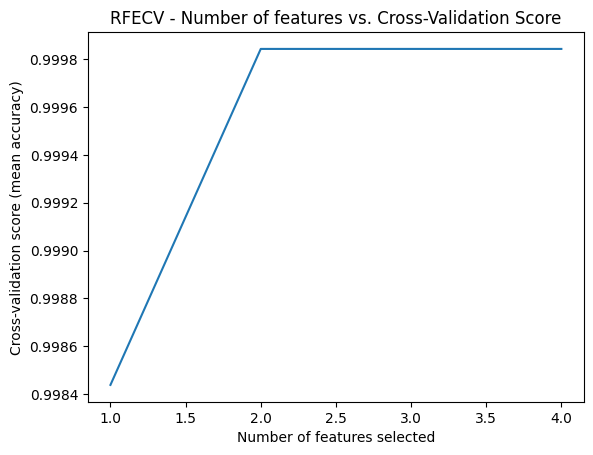

Optimal number of features : 2
Best features: Index(['predecessor_count', 'alternative_resource_allocation'], dtype='object')


In [224]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
import matplotlib.pyplot as plt


# Prepare the data
X = train_df.drop(['label'], axis=1)
y = train_df['label']

# Define the estimator; here we use XGBoost
estimator = XGBClassifier(n_estimators=100, learning_rate=0.1)

# Define the method of cross-validation
cv_strategy = StratifiedKFold(n_splits=5)

# Create the RFECV object
rfecv = RFECV(estimator=estimator, step=1, cv=cv_strategy, scoring='accuracy', min_features_to_select=1)

# Fit RFECV
rfecv.fit(X, y)

# Access the cv_results_
cv_results = rfecv.cv_results_

# Plot number of features VS. cross-validation scores
plt.figure()
plt.title('RFECV - Number of features vs. Cross-Validation Score')
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (mean accuracy)")
plt.plot(range(1, len(cv_results['mean_test_score']) + 1), cv_results['mean_test_score'])
plt.show()

# Check selected features
print("Optimal number of features : %d" % rfecv.n_features_)
print('Best features:', X.columns[rfecv.support_])


In [253]:
from sklearn.model_selection import train_test_split

x = train_df.drop(['label'], axis = 1)
y = train_df['label']
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state = 0)
x

,node1,node2,successor_count,predecessor_count
0,29237,16563,1,1
1,32869,24548,0,0
2,48837,17831,2,1
3,31387,44509,0,0
4,15102,10271,2,1
...,...,...,...,...
31995,51510,44952,1,1
31996,30089,48199,0,0
31997,1418,13815,0,0
31998,5451,24600,9,9


In [254]:
x_test = test_df.drop(['idx'], axis = 1)
x_test

,node1,node2,successor_count,predecessor_count
0,5416,45023,18,8
1,6681,40749,0,0
2,44162,40953,0,1
3,51387,51233,4,13
4,6498,24093,2,1
...,...,...,...,...
7995,15213,5972,0,0
7996,30870,8448,0,0
7997,5409,49118,0,0
7998,14298,45426,0,0


## xgboost

In [255]:
from xgboost import XGBClassifier

# 建立 XGBClassifier 模型
xgboostModel = XGBClassifier(n_estimators=10, learning_rate= 0.1)
# 使用訓練資料訓練模型
xgboostModel_fit = xgboostModel.fit(train_df.drop(['label'], axis = 1),train_df['label'])
predictions = xgboostModel_fit.predict(X_test)
predictions



array([0, 1, 1, ..., 0, 0, 1])

In [256]:
#載入classification report & confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

[[5677   83]
 [   0 3840]]


              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5760
           1       0.98      1.00      0.99      3840

    accuracy                           0.99      9600
   macro avg       0.99      0.99      0.99      9600
weighted avg       0.99      0.99      0.99      9600



In [257]:
predictions_xgboost = xgboostModel_fit.predict(x_test)
len(predictions_xgboost)

8000

In [258]:
predictions_xgboost = predictions_xgboost.tolist()

In [259]:
submission_df = pd.read_csv('C:/Users/Administrator/Desktop/台科/課程/112-2 社群分析/112-2 Social Media Analytics/hw1 Linkprediction/2024-ntust-practice-of-social-media-analytics-hw1/sample_submission.csv')
submission_xgboost = pd.DataFrame({ 'idx': submission_df.idx.values, 'ans': predictions_xgboost })
submission_xgboost.to_csv("submission_xgboost.csv", index=False)

#### 0.80553

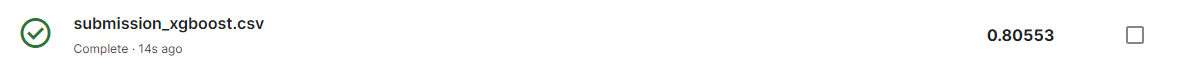